**Parameters to reproduce the paper's results**:
* change the optimizer from SGD to Adam in `lib/models.py`,
* change the size of the vocabulary from 1000 to 10000 in `train.keep_top_words()` below.

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time

%matplotlib inline

/home/vinh/anaconda3/envs/graph_cnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vinh/anaconda3/envs/graph_cnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vinh/anaconda3/envs/graph_cnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vinh/anaconda3/envs/graph_cnn/lib/pyt

In [2]:
# flags = tf.app.flags
# FLAGS = flags.FLAGS

# # Graphs.
# flags.DEFINE_integer('number_edges', 16, 'Graph: minimum number of edges per vertex.')
# flags.DEFINE_string('metric', 'cosine', 'Graph: similarity measure (between features).')
# # TODO: change cgcnn for combinatorial Laplacians.
# flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
# flags.DEFINE_integer('coarsening_levels', 0, 'Number of coarsened graphs.')

# flags.DEFINE_string('dir_data', os.path.join('..', 'data', '20news'), 'Directory to store data.')
# flags.DEFINE_integer('val_size', 400, 'Size of the validation set.')

from easydict import EasyDict as edict

FLAGS = edict({
    'number_edges': 16,
    'metric': 'cosine',
    'normalized_laplacian': True,
    'coarsening_levels': 0,
    'dir_data': os.path.join('..', 'data', '20news'),
    'val_size': 400
})

# Data

In [3]:
# Fetch dataset. Scikit-learn already performs some cleaning.
remove = ('headers','footers','quotes')  # (), ('headers') or ('headers','footers','quotes')
train = utils.Text20News(data_home=FLAGS.dir_data, subset='train', remove=remove)

# Pre-processing: transform everything to a-z and whitespace.
print(train.show_document(1)[:400])
train.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
train.vectorize(stop_words='english')
print(train.show_document(1)[:400])

N = 11314 documents, C = 20 classes
document 1: label 4 --> comp.sys.mac.hardware, 90 words
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the nex
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  1.00 "adapters" (669)
  2.00 "add" (684)
  1.00 "answered" (2523)
  1.00 "attained" (3941)
  1.00 "base" (5026)
  1.00 "brave" (7179)
  1.00 "brief" (7318)
  1.00 "cards" (8579)
  2.00 "clock" (10473)
  1.00 "cpu" (12728)
  1.00 "day" (14053)
  1.00 "days" (14068)
  1.00 "detailing" (15215)
  1.00 "disk" (16087)
  1.00 "especially" (19550)
  2.00 "experiences" (20279)
  1.00 "fair" (20691)
  1.00 "floppies" (22013)
  1.00 "floppy" (22014)
  1.00

N = 11314 documents, M = 72607 words, sparsity=0.0852%
    480 documents in class  0 (alt.atheism)
    584 documents in class  1 (comp.graphics)
    591 documents in class  2 (comp.os.ms-windows.misc)
    590 documents in class  3 (comp.sys.ibm.pc.hardware)
    578 documents in class  4 (comp.sys.mac.hardware)
    593 documents in class  5 (comp.windows.x)
    585 documents in class  6 (misc.forsale)
    594 documents in class  7 (rec.autos)
    598 documents in class  8 (rec.motorcycles)
    597 documents in class  9 (rec.sport.baseball)
    600 documents in class 10 (rec.sport.hockey)
    595 documents in class 11 (sci.crypt)
    591 documents in class 12 (sci.electronics)
    594 documents in class 13 (sci.med)
    593 documents in class 14 (sci.space)
    599 documents in class 15 (soc.religion.christian)
    546 documents in class 16 (talk.politics.guns)
    564 documents in class 17 (talk.politics.mideast)
    465 documents in class 18 (talk.politics.misc)
    377 documents in cl

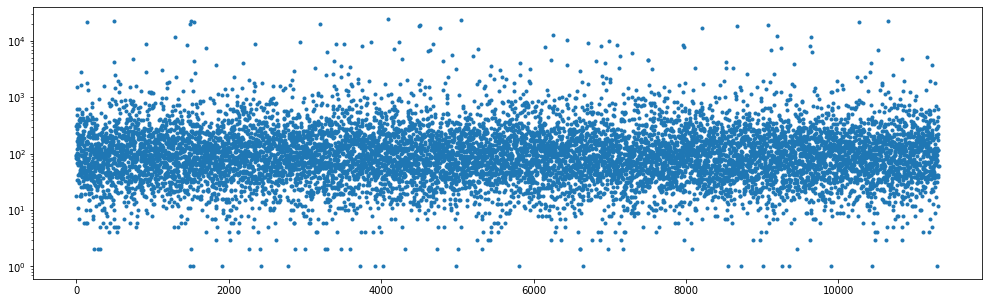

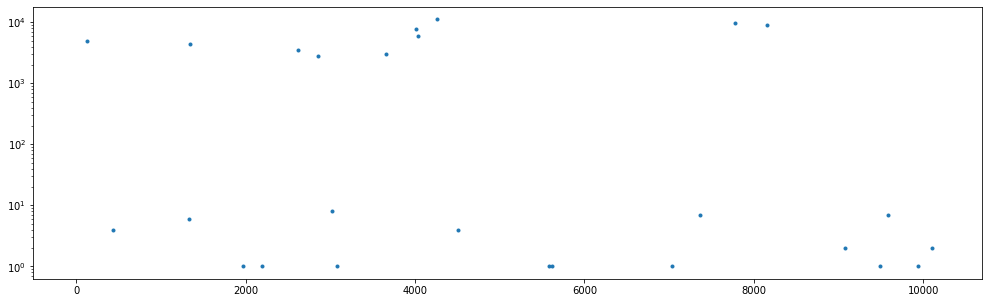

In [4]:
# Remove short documents.
train.data_info(True)
wc = train.remove_short_documents(nwords=20, vocab='full')
train.data_info()
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

# Remove encoded images.
def remove_encoded_images(dataset, freq=1e3):
    widx = train.vocab.index('ax')
    wc = train.data[:,widx].toarray().squeeze()
    idx = np.argwhere(wc < freq).squeeze()
    dataset.keep_documents(idx)
    return wc
wc = remove_encoded_images(train)
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

In [5]:
# Word embedding
# if True:
#     train.embed()
# else:
#     train.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))

train.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))

train.data_info()
# Further feature selection. (TODO)

33838 words not found in corpus
N = 10171 documents, M = 38769 words, sparsity=0.1613%


most frequent words
    0: num        163934 counts
    1: dollar      10562 counts
    2: people       4093 counts
    3: like         3942 counts
    4: don          3869 counts
    5: just         3721 counts
    6: know         3464 counts
    7: use          3166 counts
    8: think        2995 counts
    9: time         2966 counts
   10: does         2749 counts
   11: new          2606 counts
   12: good         2492 counts
   13: edu          2416 counts
   14: way          2032 counts
   15: make         2022 counts
   16: god          1976 counts
   17: used         1874 counts
   18: ve           1857 counts
   19: say          1841 counts
N = 10171 documents, M = 10000 words, sparsity=0.5537%
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  3.00 "num" (0)
  1.00 "number" (40)
  1.00 "thanks" (48)
  1.00 "day" (76)
  1.00 "send" (97)
  1.00 "disk" (156)
  1.00 "message" (206)
  2.00 "speed" (226)
  1.00 "days" (244)
  1.00 "especially" (383)
  2.00 "add" (439)
  1.

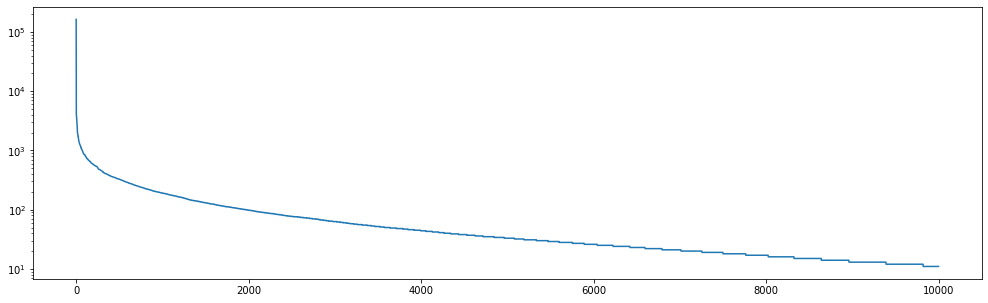

In [6]:
# Feature selection.
# Other options include: mutual information or document count.
freq = train.keep_top_words(10000, 20)
train.data_info()
train.show_document(1)
plt.figure(figsize=(17,5))
plt.semilogy(freq)

# Remove documents whose signal would be the zero vector.
wc = train.remove_short_documents(nwords=5, vocab='selected')
train.data_info(True)

In [7]:
train.normalize(norm='l1')
train.show_document(1)

document 1: label 4 --> comp.sys.mac.hardware, 92 words
  0.06 "num" (0)
  0.02 "number" (40)
  0.02 "thanks" (48)
  0.02 "day" (76)
  0.02 "send" (97)
  0.02 "disk" (156)
  0.02 "message" (206)
  0.04 "speed" (226)
  0.02 "days" (244)
  0.02 "especially" (383)
  0.04 "add" (439)
  0.02 "haven" (465)
  0.02 "network" (527)
  0.02 "cards" (590)
  0.02 "knowledge" (612)
  0.02 "base" (708)
  0.02 "floppy" (753)
  0.04 "clock" (970)
  0.02 "cpu" (1134)
  0.02 "si" (1159)
  0.02 "fair" (1191)
  0.02 "upgrade" (1418)
  0.02 "heat" (1617)
  0.02 "shared" (1742)
  0.02 "hour" (1842)
  0.02 "usage" (1921)
  0.02 "answered" (2284)
  0.04 "experiences" (2420)
  0.02 "procedure" (2431)
  0.02 "functionality" (3366)
  0.02 "brief" (3452)
  0.02 "requested" (3670)
  0.02 "rated" (3888)
  0.02 "floppies" (4186)
  0.02 "upgraded" (4470)
  0.02 "souls" (5306)
  0.04 "poll" (6081)
  0.02 "adapters" (6298)
  0.02 "oscillator" (6366)
  0.02 "brave" (7366)


'a fair number of brave souls who upgraded their si clock oscillator have shared their experiences for this poll please send a brief message detailing your experiences with the procedure top speed attained cpu rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with num and num num m floppies are especially requested i will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and haven t answered this poll thanks'

In [8]:
# Test dataset.
test = utils.Text20News(data_home=FLAGS.dir_data, subset='test', remove=remove)
test.clean_text(num='substitute')
test.vectorize(vocabulary=train.vocab)
test.data_info()
wc = test.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
test.data_info(True)
test.normalize(norm='l1')

N = 7532 documents, C = 20 classes
N = 7532 documents, M = 10000 words, sparsity=0.4757%
shortest: 0, longest: 30817 words
N = 7065 documents, M = 10000 words, sparsity=0.5062%
    299 documents in class  0 (alt.atheism)
    374 documents in class  1 (comp.graphics)
    374 documents in class  2 (comp.os.ms-windows.misc)
    377 documents in class  3 (comp.sys.ibm.pc.hardware)
    361 documents in class  4 (comp.sys.mac.hardware)
    374 documents in class  5 (comp.windows.x)
    373 documents in class  6 (misc.forsale)
    359 documents in class  7 (rec.autos)
    364 documents in class  8 (rec.motorcycles)
    361 documents in class  9 (rec.sport.baseball)
    379 documents in class 10 (rec.sport.hockey)
    364 documents in class 11 (sci.crypt)
    374 documents in class 12 (sci.electronics)
    368 documents in class 13 (sci.med)
    369 documents in class 14 (sci.space)
    380 documents in class 15 (soc.religion.christian)
    339 documents in class 16 (talk.politics.guns)
    35

In [9]:
if True:
    train_data = train.data.astype(np.float32)
    test_data = test.data.astype(np.float32)
    train_labels = train.labels
    test_labels = test.labels
else:
    perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
    Ntest = 6695
    perm_test = perm[:Ntest]
    perm_train = perm[Ntest:]
    train_data = train.data[perm_train,:].astype(np.float32)
    test_data = train.data[perm_test,:].astype(np.float32)
    train_labels = train.labels[perm_train]
    test_labels = train.labels[perm_test]

if True:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = train.data.T.astype(np.float32).toarray()

#del train, test

# Feature graph

In [10]:
t_start = time.process_time()
dist, idx = graph.distance_sklearn_metrics(graph_data, k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

113439 > 80000 edges
Layer 0: M_0 = |V| = 10000 nodes (0 added),|E| = 113439 edges
Execution time: 17.98s


In [11]:
t_start = time.process_time()
train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

Execution time: 1.37s


# Classification

In [12]:
# Training set is shuffled already.
#perm = np.random.permutation(train_data.shape[0])
#train_data = train_data[perm,:]
#train_labels = train_labels[perm]

# Validation set.
if False:
    val_data = train_data[:FLAGS.val_size,:]
    val_labels = train_labels[:FLAGS.val_size]
    train_data = train_data[FLAGS.val_size:,:]
    train_labels = train_labels[FLAGS.val_size:]
else:
    val_data = test_data
    val_labels = test_labels

In [13]:
if True:
    utils.baseline(train_data, train_labels, test_data, test_labels)

Train accuracy:      35.05 51.11 85.77 99.95 91.43 79.52 84.23
Test accuracy:       20.52 42.04 58.33 61.83 67.33 63.35 65.29
Train F1 (weighted): 36.84 49.90 85.86 99.95 91.02 79.03 83.91
Test F1 (weighted):  19.84 40.49 58.52 60.97 65.69 62.07 64.18
Execution time:       6.47 123.62  0.08 18.14  0.04  0.49  2.19


In [14]:
common = {}
common['dir_name']       = '20news/'
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [15]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 1e3
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 10000
  layer 1: logits (softmax)
    representation: M_1 = 20
    weights: M_0 * M_1 = 10000 * 20 = 200000
    biases: M_1 = 20
step 400 / 8134 (epoch 3.93 / 80):
  learning_rate = 8.57e+02, loss_average = 1.04e+03
  validation accuracy: 9.33 (659 / 7065), f1 (weighted): 3.44, loss: 1.09e+03
  time: 6s (wall 4s)
step 800 / 8134 (epoch 7.87 / 80):
  learning_rate = 6.98e+02, loss_average = 5.81e+02
  validation accuracy: 17.95 (1268 / 7065), f1 (weighted): 16.53, loss: 5.69e+02
  time: 11s (wall 8s)
step 1200 / 8134 (epoch 11.80 / 80):
  learning_rate = 5.69e+02, loss_average = 3.02e+01
  validation accuracy: 55.16 (3897 / 7065), f1 (weighted): 54.50, loss: 4.20e+01
  time: 17s (wall 12s)
step 1600 / 8134 (epoch 15.74 / 80):
  learning_rate = 4.63e+02, loss_average = 1.39e+01
  validation accuracy: 59.14 (4178 / 7065), f1 (weighted): 57.60, loss: 3.42e+01
  time: 22s (wall 15s)
step 2000 / 8134 (epoch 19.67 / 80):
  learning_rate = 3.77e+02, loss_average 

In [16]:
if True:
    name = 'fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 10000
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 10000 * 2500 = 25000000
    biases: M_1 = 2500
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 2500 * 20 = 50000
    biases: M_2 = 20
step 400 / 8134 (epoch 3.93 / 80):
  learning_rate = 8.57e-02, loss_average = 2.52e+00
  validation accuracy: 28.32 (2001 / 7065), f1 (weighted): 23.39, loss: 2.59e+00
  time: 435s (wall 80s)
step 800 / 8134 (epoch 7.87 / 80):
  learning_rate = 6.98e-02, loss_average = 2.14e+00
  validation accuracy: 44.25 (3126 / 7065), f1 (weighted): 43.31, loss: 2.27e+00
  time: 893s (wall 156s)
step 1200 / 8134 (epoch 11.80 / 80):
  learning_rate = 5.69e-02, loss_average = 1.79e+00
  validation accuracy: 48.37 (3417 / 7065), f1 (weighted): 46.47, loss: 2.02e+00
  time: 1354s (wall 229s)
step 1600 / 8134 (epoch 15.74 / 80):
  learning_rate = 4.63e-02, loss_average = 1.60e+00
  validation accuracy: 51.01 (3604 / 7065), f1 (weight

In [17]:
if True:
    name = 'fc_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, 500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 10000
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 10000 * 2500 = 25000000
    biases: M_1 = 2500
  layer 2: fc2
    representation: M_2 = 500
    weights: M_1 * M_2 = 2500 * 500 = 1250000
    biases: M_2 = 500
  layer 3: logits (softmax)
    representation: M_3 = 20
    weights: M_2 * M_3 = 500 * 20 = 10000
    biases: M_3 = 20
step 400 / 8134 (epoch 3.93 / 80):
  learning_rate = 8.57e-02, loss_average = 2.59e+00
  validation accuracy: 13.79 (974 / 7065), f1 (weighted): 9.47, loss: 2.65e+00
  time: 492s (wall 86s)
step 800 / 8134 (epoch 7.87 / 80):
  learning_rate = 6.98e-02, loss_average = 2.42e+00
  validation accuracy: 20.62 (1457 / 7065), f1 (weighted): 13.52, loss: 2.50e+00
  time: 991s (wall 163s)
step 1200 / 8134 (epoch 11.80 / 80):
  learning_rate = 5.69e-02, loss_average = 1.70e+00
  validation accuracy: 40.79 (2882 / 7065), f1 (weighted): 38.27, loss: 1.82e+00
  time: 1491s (wall 238s)
step 1600 / 8134 (epoch 15.74 / 8

In [18]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'fourier'
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.001
    params['decay_rate']     = 1
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [L[0].shape[0]]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 10000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 10000 * 32 / 1 = 320000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 10000 = 320000
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 320000 * 20 = 6400000
    biases: M_2 = 20
step 400 / 8134 (epoch 3.93 / 80):
  learning_rate = 1.00e-03, loss_average = 3.00e+00
  validation accuracy: 5.21 (368 / 7065), f1 (weighted): 0.77, loss: 3.01e+00
  time: 42988s (wall 5705s)
step 800 / 8134 (epoch 7.87 / 80):
  learning_rate = 1.00e-03, loss_average = 3.00e+00
  validation accuracy: 5.29 (374 / 7065), f1 (weighted): 0.53, loss: 3.02e+00
  time: 86055s (wall 11395s)


KeyboardInterrupt: 

In [ ]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'spline'
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [5]
    params['K']              = [15]
    params['p']              = [1]
    params['M']              = [100, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
model_perf.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))